In [1]:
import os
import random
import copy
import datetime, time
from PIL import Image
import numpy as np
from collections import deque
%matplotlib inline
import matplotlib.pyplot as plt

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
import gym_super_mario_bros

from nes_py.wrappers import JoypadSpace

import tensorflow as tf

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def display_image(next_state, to_grayscale=False):
    next_state_cont = np.ascontiguousarray(next_state)
    if to_grayscale:
        next_state_cont = tf.image.rgb_to_grayscale(next_state_cont)
    plt.imshow(next_state_cont)

In [4]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
# 0. walk right
# 1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])
env.reset()
next_state, reward, done, info = env.step(action=0)
next_state.shape, reward, done, info

((240, 256, 3),
 0,
 False,
 {'coins': 0,
  'flag_get': False,
  'life': 2,
  'score': 0,
  'stage': 1,
  'status': 'small',
  'time': 400,
  'world': 1,
  'x_pos': 40,
  'x_pos_screen': 40,
  'y_pos': 79})

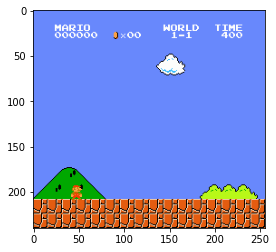

In [5]:
# Check the first state of the Mario game image
display_image(next_state)

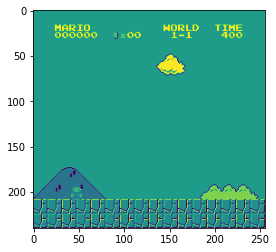

In [6]:
display_image(next_state, to_grayscale=True)

In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """ Return only every 'skip'-th frame """
        super().__init__(env)
        self._skip = skip
        
    def step(self, action):
        """ Repeat action, and sum reward """
        total_rewards = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate rewards and repeat the same action
            next_state, reward, done, info = self.env.step(action)
            total_rewards += reward
            if done:
                break
        return next_state, total_rewards, done, info

    
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        
    def convert_numpy_to_tensor(self, observation):
        observation = tf.convert_to_tensor(observation.copy(), dtype=tf.float32)
        return observation
    
    def observation(self, observation):
        observation = self.convert_numpy_to_tensor(observation)
        observation = tf.image.rgb_to_grayscale(observation)
        return observation

    
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        assert isinstance(shape, int), "dtype of shape has to be int. {} is what we get.".format(type(shape))
        self.shape = (shape, shape)

        # tuple + tuple: e.g. (240, 256) + (3,) = (240, 256, 3)
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        
    def observation(self, observation):
        observation = tf.image.resize(observation, self.shape)
        observation /= 255
        return observation

In [8]:
# Apply wrappers to the environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)

In [9]:
next_state, reward, done, info = env.step(action=1)
next_state.shape, reward, done, info

(TensorShape([84, 84, 1]),
 0.0,
 False,
 {'coins': 0,
  'flag_get': False,
  'life': 2,
  'score': 0,
  'stage': 1,
  'status': 'small',
  'time': 400,
  'world': 1,
  'x_pos': 40,
  'x_pos_screen': 40,
  'y_pos': 93})

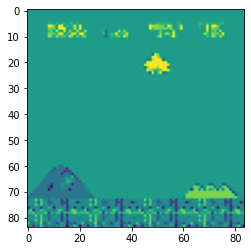

In [10]:
display_image(next_state)

In [11]:
env = FrameStack(env, num_stack=4)

In [12]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        # Specify the max element length of 100000 for the deque
        self.memory = deque(maxlen=100000)
        self.batch_size = 32
        # Mario's DNN to predict the most optimal action.
        # We implement this in the Learn section
        self.online_net = MarioNet(self.state_dim, self.action_dim)
        self.target_net = MarioNet(self.state_dim, self.action_dim)
        self.exploration_rate = tf.Variable(1.0)
        self.exploration_rate_decay = tf.constant(0.99999975)
        self.exploration_rate_min = 0.1
        self.gamma = 0.9
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025)
        self.loss_fn = tf.keras.losses.Huber()
        self.curr_step = 0
        # The number of experiences between saving Mario Net
        self.save_every = 5e5
        self.burnin = 1e4 # min. experiences before training
        self.learn_every = 3 # number of experiences between updates to Q_online
        self.sync_every = 1e4 # number of experiences between Q_target & Q_online sync
    
    def act(self, state):
        """ 
        Given a state, choose an epsilon-greedy action and update value of step.
        
        Inputs:
        state(LazyFrame): A single observation of the current state, The dimenstion: state_dim
        Outputs:
        action_idx(int): An integer representing which action Mario will perform
        """
        # Explore
        if np.random.rand() < self.exploration_rate.numpy():
            action_idx = np.random.randint(self.action_dim)    
        # Exploit
        else:
            state = state.__array__()
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            action_values = self.online_net(state)
            action_idx = tf.math.argmax(action_values, axis=1)
            
        # decreate exploration rate
        self.exploration_rate = self.exploration_rate * self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate, self.exploration_rate_min)
        
        # increment step
        self.curr_step += 1
        return action_idx
    
    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience(current sate, action performed, reward from the action,
        nest state, whether the game is done) to self.memory (replay buffer)
        
        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done (bool)
        """
        state = state.__array__()
        next_state = next_state.__array__()
        
        state = tf.convert_to_tensor(state)
        next_state = tf.convert_to_tensor(next_state)
        action = tf.constant([action])
        reward = tf.constant([reward])
        done = tf.constant([done])
        
        self.memory.append((state, next_state, action, reward, done))
    
    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(tf.stack, zip(*batch))
        return state, next_state, tf.squeeze(action), tf.squeeze(reward), tf.squeeze(done)
    
    def td_estimate(self, state, action):
        current_Q = self.online_net(state)[np.arange(0, self.batch_size), action] # Q_online(s, a)
        return current_Q
    
    def td_target(self, reward, next_state, done):
        next_state_Q = self.online_net(next_state)
        best_action = tf.math.argmax(next_state_Q, axis=1)
        next_Q = self.target_net(next_state)[np.arange(0, self.batch_size), best_action]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def train_step(state, next_state, action, reward, done):
        td_tgt = self.td_target(reward, next_state, done)
        with tf.GradientTape() as tape:
            td_est = self.td_estimate(state, action)
            loss = self.loss_fn(td_tgt, td_est)
        
        gradients = tape.gradient(loss, self.online_net.trainable_variables)
        self.optimizer.apply_gradient(zip(gradients, self.online_net.trainable_variables))
        
        return td_est, loss
            
    def sync_Q_target(self):
        self.target_net.set_weights(self.online_net.get_weights())
            
    def learn(self, ckpt_manager):
        """ Update online action value (Q) function with a batch of experiences """
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()
            
        if self.curr_step % self.save_every == 0:
            save_path = ckpt_manager.save()
            print(f"Saved checkpoint for step {self.curr_step}: {save_path}")
        
        if self.curr_step < self.burnin:
            return None, None
        
        if self.curr_step % self.learn_every != 0:
            return None, None
        
        # Sample from memory
        state, next_state, action, reward, done = self.recall()
        
        td_est, loss = self.train_step(state, next_state, action, reward, done)
        
        return tf.reduce_mean(td_est), loss

In [13]:
class MarioNet(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super(MarioNet, self).__init__()
        h, w, _ = input_dim
        
        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")
            
        self.conv_net = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(32, 8, 4),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Conv2D(64, 4, 2),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Conv2D(64, 3, 1),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(512),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Dense(output_dim)])
        
    def call(self, inputs):
        return self.conv_net(inputs)
    
    def summary(self):
        x = tf.keras.layers.Input(shape=(84, 84, 3))
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [14]:
net = MarioNet((84, 84, 3), 3)
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 3)                 1683619   
Total params: 1,683,619
Trainable params: 1,683,619
Non-trainable params: 0
_________________________________________________________________


In [18]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = os.path.join(save_dir, "logs")
        with open(self.save_log, "w")as f:
            f.write(f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                    f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                    f"{'TimeDelta':>15}{'Time':>20}\n")
        
        self.ep_rewards_plot = os.path.join(save_dir, "reward_plot.jpg")
        self.ep_lengths_plot = os.path.join(save_dir, "length_plot.jpg")
        self.ep_avg_losses_plot = os.path.join(save_dir, "loss_plot.jpg")
        self.ep_avg_qs_plot = os.path.join(save_dir, "q_plot.jpg")
        
        # HIstory metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []
        
        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []
        
        # Current episode metric
        self.init_episode()
        
        # Timing
        self.record_time = time.time()
        
    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length +=1
            
    def log_episode(self):
        """ Mark end of episode """
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)
        
        self.init_episode()
        
    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0
        
    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)
        
        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)
        
        print(f"Episode {episode} - "
              f"Step {step} - "
              f"Epsilon {epsilon} - "
              f"Mean Reward {mean_ep_reward} - "
              f"Mean Length {mean_ep_length} - "
              f"Mean Loss {mean_ep_loss} - "
              f"Mean Q Value {mean_ep_q} - "
              f"Time Delta {time_since_last_record} - "
              f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}")
        
        with open(self.save_log, "a") as f:
            f.write(f"{episode:8d}{step:8d}{epsilon:10.3f}"
                    f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                    f"{time_since_last_record: 15.3f}"
                    f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n")
            
        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

In [19]:
class Trainer:
    def __init__(self):
        self.save_dir = os.path.join("ckpts", datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.save_dir, exist_ok=True)
        self.mario = Mario(state_dim=(84, 84, 4), 
                           action_dim=env.action_space.n, 
                           save_dir=self.save_dir)
        self.logger = MetricLogger(self.save_dir)
        
    def set_ckpt_and_manager(self):
        self.ckpt = tf.train.Checkpoint(step=tf.Variable(0),
                                        exploration_rate=self.mario.exploration_rate,
                                        optimizer=self.mario.optimizer,
                                        online_net=self.mario.online_net)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt,
                                                      self.save_dir,
                                                      max_to_keep=5)

    def train_and_checkpoint(self, num_episode):
        self.set_ckpt_and_manager()
        self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
        if self.ckpt_manager.latest_checkpoint:
            print(f"Restored from {self.ckpt_manager.latest_checkpoint}")
        else:
            print("Initializing from scratch.")

        for e in range(num_episode):
            state = env.reset()

            # Play for each episode
            while True:
                # Run agent on the state
                action = self.mario.act(state)
                # Agent performs action
                next_state, reward, done, info = env.step(action)
                # Remember
                self.mario.cache(state, next_state, action, reward, done)
                #Learn
                q, loss = self.mario.learn(self.ckpt_manager)
                # Logging
                self.logger.log_step(reward, loss, q)
                # Update state
                state = next_state
                # Check if end of game
                if done or info["flag_get"]:
                    break

            self.logger.log_episode()

            if e % 20 == 0:
                self.logger.record(episode=e, epsilon=self.mario.exploration_rate, step=self.mario.curr_step)

In [20]:
trainer = Trainer()
trainer.train_and_checkpoint(10)

Initializing from scratch.


AttributeError: 'MetricLogger' object has no attribute 'moving_avg_ep_lengths'